In [1]:
import numpy as np
from math import *

In [2]:
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_RATE = 0.9
RENTAL_CREDIT = 10
COST_OF_MOVING = 2

In [3]:
policy = np.zeros((MAX_CARS+1, MAX_CARS+1))
stateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))

In [4]:
states = []
for i in range(MAX_CARS+1):
    for j in range(MAX_CARS+1):
        states.append([i,j])

In [5]:
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS+1)

In [6]:
pBackup = dict()

def poisson(x, lam):
    global pBackup
    key = x*10 + lam
    if key not in pBackup.keys():
        pBackup[key] = np.exp(-lam) * pow(lam,x) / factorial(x)
    return pBackup[key]

In [7]:
POISSON_UPPER_BOUND = 11

In [8]:
newStateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))
improvePolicy = False
policyStable = False

In [9]:
def expectedReturn(state, action, stateValue):
    # Initiate and populate returns with cost associated with moving cars
    returns = 0.0
    returns -= COST_OF_MOVING * np.absolute(action)
    # Number of cars to start the day
    carsLoc1 = int(min(state[0] - action, MAX_CARS))
    carsLoc2 = int(min(state[1] + action, MAX_CARS))
    # Iterate over Rental Rates
    for rentalsLoc1 in range(0, POISSON_UPPER_BOUND):
        for rentalsLoc2 in range(0, POISSON_UPPER_BOUND):
            # Rental Probabilities
            rentalsProb = poisson(rentalsLoc1, EXPECTED_FIRST_LOC_REQUESTS) * poisson(rentalsLoc2, EXPECTED_SECOND_LOC_REQUESTS)
            # Total Rentals
            totalRentalsLoc1 = min(carsLoc1, rentalsLoc1)
            totalRentalsLoc2 = min(carsLoc2, rentalsLoc2)
            # Total Rewards
            rewards = (totalRentalsLoc1 + totalRentalsLoc2) * RENTAL_CREDIT
            # Iterate over Return Rates
            for returnsLoc1 in range(0, POISSON_UPPER_BOUND):
                for returnsLoc2 in range(0, POISSON_UPPER_BOUND):
                    # Return Rate Probabilities
                    prob = poisson(returnsLoc1, EXPECTED_FIRST_LOC_RETURNS) * poisson(returnsLoc2, EXPECTED_SECOND_LOC_RETURNS) * rentalsProb
                    # Number of cars at the end of the day
                    carsLoc1_prime = min(carsLoc1 - totalRentalsLoc1 + returnsLoc1, MAX_CARS)
                    carsLoc2_prime = min(carsLoc2 - totalRentalsLoc2 + returnsLoc2, MAX_CARS)
                    # Number of cars at the end of the day
                    returns += prob * (rewards + DISCOUNT_RATE * stateValue[carsLoc1_prime, carsLoc2_prime])
    return returns

In [10]:
k = 0
policy_list = [policy]

while policyStable == False:
    ## Policy Evaluation
    print("Policy Eval")
    for i,j in states:
        newStateVal[i,j] = expectedReturn([i,j], policy[i,j], stateVal)
    print(np.max(np.absolute(newStateVal-stateVal)))
    if np.max(np.absolute(newStateVal-stateVal)) < 1e-4:
        print("Almost converged")
        improvePolicy = True
    
    stateVal = newStateVal.copy()

    ## Policy Improvement
    if improvePolicy == True:
        print("Improve Policy: ", k)
        newPolicy = np.zeros((MAX_CARS+1, MAX_CARS+1))
        for i,j in states:
            actionReturns = []
            for action in actions:
                if ((action >= 0) and (i >= action)) or ((action < 0) and j >= np.absolute(action)):
                    actionReturns.append(expectedReturn([i,j], action, stateVal))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[i,j] = actions[bestAction]
        policyChanges = np.sum(newPolicy != policy)


        if policyChanges == 0:
            policyStable = True
        else:
            policy = newPolicy
            improvePolicy = False
            policy_list.append(policy)


        k += 1
    
# exec time: 52 min

Policy Eval
69.52403001982688
Policy Eval
62.356945376495986
Policy Eval
55.91609079532296
Policy Eval
49.97765212138614
Policy Eval
44.21473338943164
Policy Eval
38.56425952483767
Policy Eval
33.24853780973956
Policy Eval
28.51032796962363
Policy Eval
24.460537389917818
Policy Eval
21.082083812403482
Policy Eval
18.28818071148629
Policy Eval
15.972272582946516
Policy Eval
14.035402699142423
Policy Eval
12.396352967870541
Policy Eval
10.992525159734555
Policy Eval
9.777091475219038
Policy Eval
8.715316483419315
Policy Eval
7.78126442964674
Policy Eval
6.955238700658015
Policy Eval
6.221930138012681
Policy Eval
5.569131504367874
Policy Eval
4.986864315491175
Policy Eval
4.46679071628796
Policy Eval
4.001816298405288
Policy Eval
3.5858185168640375
Policy Eval
3.213457034237308
Policy Eval
2.880037503836661
Policy Eval
2.581410486246
Policy Eval
2.313893829812173
Policy Eval
2.0742110910790643
Policy Eval
1.8594412520485548
Policy Eval
1.6669766728173272
Policy Eval
1.4944872693361049
Pol

In [13]:
np.save("/system/user/studentwork/mederits/Research/RL/jacks_car_rental_policy_GPI_two_array_version.npy", policy)

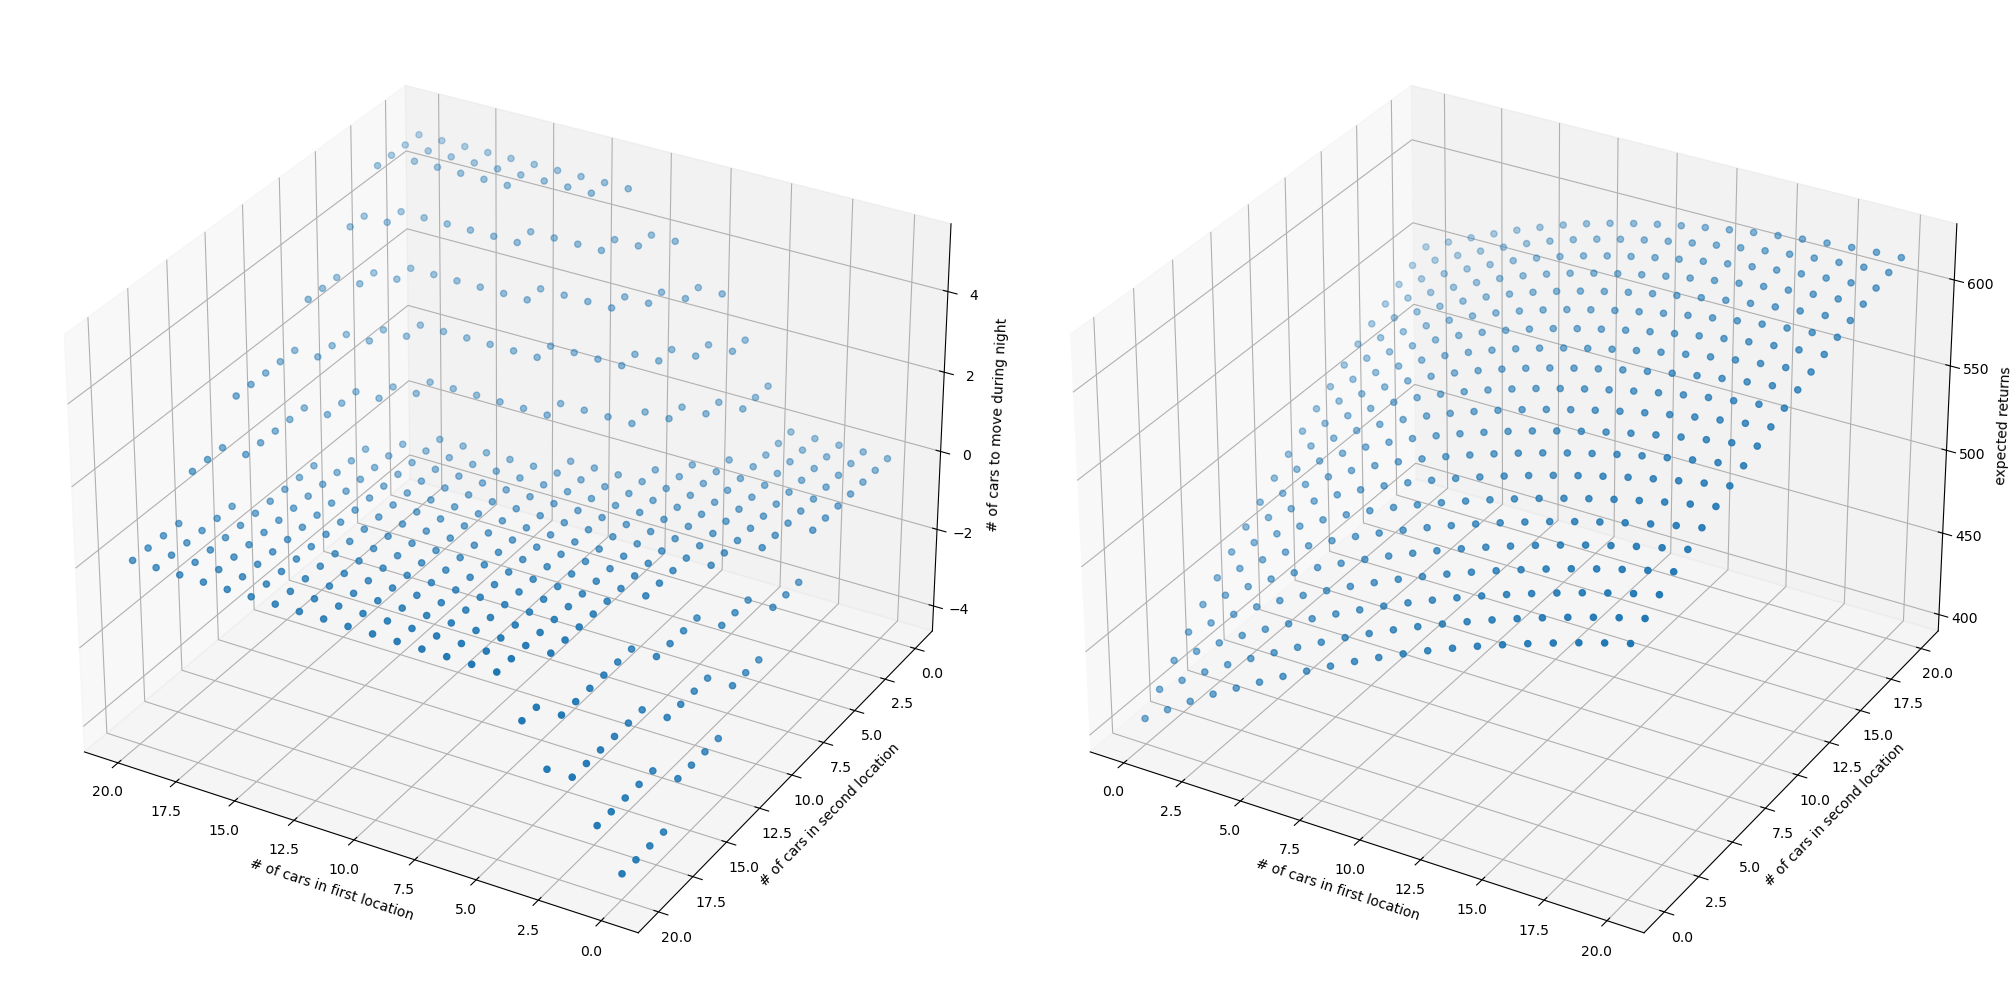

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure(figsize=(20,10), layout="constrained")
ax = fig.add_subplot(1,2,1, projection='3d')

m = 'o'

cars_loc1 = []
cars_loc2 = []
policy_list = []
value_list = []

for i,j in states:
    cars_loc1.append(i)
    cars_loc2.append(j)
    policy_list.append(policy[i,j])
    value_list.append(stateVal[i,j])

ax.scatter(cars_loc1, cars_loc2, policy_list, marker=m)

ax.set_xlabel('# of cars in first location')
ax.set_ylabel('# of cars in second location')
ax.set_zlabel('# of cars to move during night')

ax.xaxis.set_inverted(True)
ax.yaxis.set_inverted(True)

ax2 = fig.add_subplot(1,2,2, projection='3d')

ax2.scatter(cars_loc1, cars_loc2, value_list, marker=m)

ax2.set_xlabel('# of cars in first location')
ax2.set_ylabel('# of cars in second location')
ax2.set_zlabel('expected returns')

ax2.xaxis.set_inverted(False)
ax2.yaxis.set_inverted(False)

plt.show()

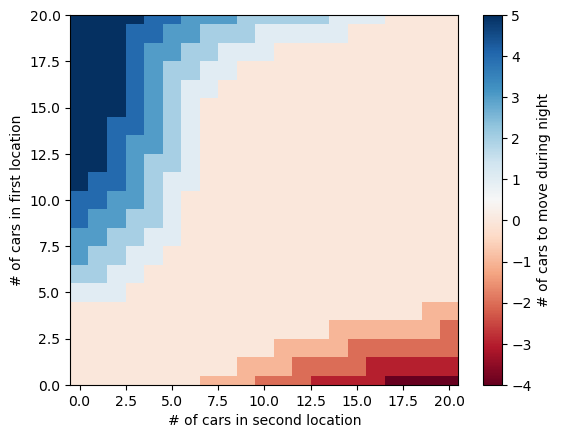

In [12]:
plt.imshow(policy, cmap='RdBu', interpolation='nearest')
plt.ylim([0,20])
cbar = plt.colorbar()
cbar.set_label('# of cars to move during night', rotation=90)


plt.xlabel("# of cars in second location")
plt.ylabel("# of cars in first location")
plt.show()